In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA not available, training on CPU ... ")
else:
    print("CUDA is available! training on GPU ... ")

CUDA is available! training on GPU ... 


In [0]:
import os

# define training and test data directories
data_dir = 'fruits-360_dataset/fruits-360/'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Test')

In [18]:
# Data augmentation: defining transforms for training, validation and test sets
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomRotation(20),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), 
                                                           (0.5, 0.5, 0.5))])
other_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), 
                                                           (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=other_transform)

# print out some data stats
print("Number of training images: ", len(train_data))
print("Number of test images: ", len(test_data))

Number of training images:  60498
Number of test images:  20622


In [0]:
# Function to extract classes from the dataset folders
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    idx_to_class = {i: classes[i] for i in range(len(classes))}
    return classes, class_to_idx, idx_to_class

In [0]:
# Defining validation set
valid_pct = 0.2
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(valid_pct * len(train_data)))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
batch_size = 32

# prepare the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [22]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

1513
379
645


In [23]:
class_names, class_idx, idx_class = find_classes(train_dir)
print(class_names)
len(class_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Eggplant', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nectarine Flat', 'Nut

120

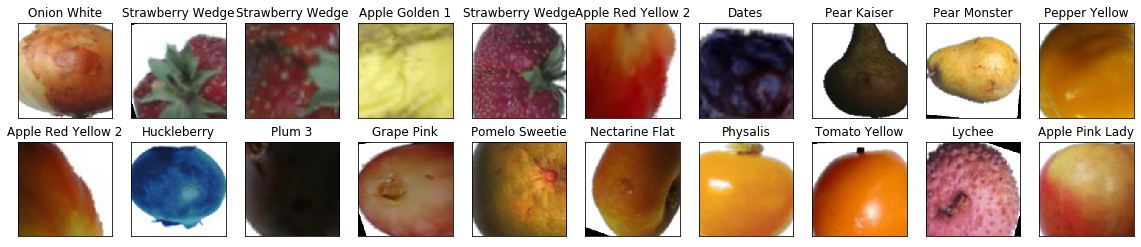

In [24]:
# Visualize some data
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy to display

images = images/2 + 0.5 # un-normalizing the images
# plot the figure
fig = plt.figure(figsize=(20,4))

for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1,2,0)))
    # ax.set_title(class_names[labels[idx]])
    ax.set_title(idx_class[int(labels[idx])])
plt.show()

In [0]:
feature_extract = False    # Fine-tune the model if set false 
def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the .requires_grad attribute of the parameters in 
    the model to False when we are feature extracting. By default, when we load 
    a pretrained model all of the parameters have .requires_grad=True, which is 
    fine if we are training from scratch or finetuning.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
# define the pretrained model from pytorch
model = models.resnet50(pretrained=True)

set_parameter_requires_grad(model, feature_extract)
# print out the model structure
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [27]:
print(model.fc.in_features)
print(model.fc.out_features)

2048
1000


In [0]:
# changing the classifier range according to the number of classes we have
fcs = nn.Sequential((nn.Linear(2048, 1000)),
                    (nn.ReLU()),
                    (nn.Linear(1000, 120))
                    )
model.fc = fcs

In [29]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=120, bias=True)
)

In [0]:
# move the model to gpu, if available
if train_on_gpu:
    model = model.cuda()

In [0]:
# Specifying loss function and optimizer
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

In [32]:
#  Gather the parameters to be optimized/updated in this run. For
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [33]:
# Training
# number of epochs to train the model
n_epochs = 10
valid_loss_min = np.Inf  # track changes in test loss
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time
for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    train_acc = 0.0
    valid_acc = 0.0
    
    # training mode
    model.train()
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # clearing the optimizer
        optimizer.zero_grad()
        
        # Feed forward
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # backprop
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # update the loss
        train_loss += loss.item()
        
        # calculate the class with max probability
        max_idx = torch.argmax(outputs, dim=1)
        corrects = (max_idx == labels.data).float().sum()
        train_acc += corrects / images.shape[0]
        
#     # evaluation mode
    model.eval()
    for images, labels in valid_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # Feed forward
        outputs = model(images)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # update the loss
        valid_loss += loss.item()
        
        # calculate the class with maximum probability
        max_idx = torch.argmax(outputs, dim=1)
        corrects = (max_idx == labels.data).float().sum()
        valid_acc += corrects / images.shape[0]
        
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_acc = 100 * (train_acc / len(train_loader))
    valid_acc = 100 * (valid_acc / len(valid_loader))
    print("Epoch: {} \t Training loss: {:.6f} \t Vaidation loss: {:.6f}".format(
        epoch+1, train_loss, valid_loss))
    print("Train accuracy: {:.3f} \t Validation accuracy: {:.3f}".format(
        train_acc, valid_acc))
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'fruits.pt')
        valid_loss_min = valid_loss

Epoch: 1 	 Training loss: 1.747888 	 Vaidation loss: 0.224073
Train accuracy: 62.718 	 Validation accuracy: 94.385
Validation loss decreased (inf --> 0.224073). Saving model ... 
Epoch: 2 	 Training loss: 0.238673 	 Vaidation loss: 0.077157
Train accuracy: 94.026 	 Validation accuracy: 98.038
Validation loss decreased (0.224073 --> 0.077157). Saving model ... 
Epoch: 3 	 Training loss: 0.133824 	 Vaidation loss: 0.052229
Train accuracy: 96.466 	 Validation accuracy: 98.442
Validation loss decreased (0.077157 --> 0.052229). Saving model ... 
Epoch: 4 	 Training loss: 0.094725 	 Vaidation loss: 0.052976
Train accuracy: 97.515 	 Validation accuracy: 98.351
Epoch: 5 	 Training loss: 0.075082 	 Vaidation loss: 0.032747
Train accuracy: 97.982 	 Validation accuracy: 99.027
Validation loss decreased (0.052229 --> 0.032747). Saving model ... 
Epoch: 6 	 Training loss: 0.064276 	 Vaidation loss: 0.028021
Train accuracy: 98.215 	 Validation accuracy: 99.118
Validation loss decreased (0.032747 -->

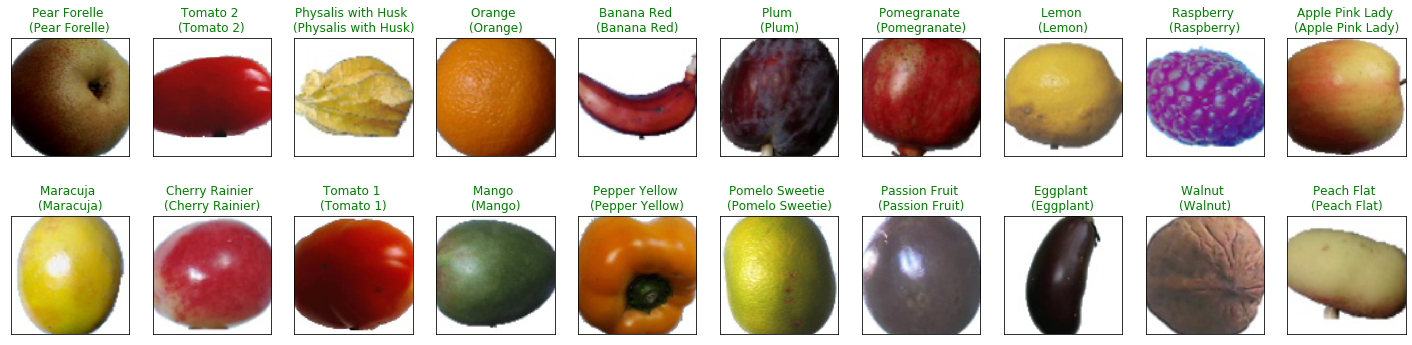

In [37]:
## Testing the model
dataiter = iter(test_loader)
images, labels = next(dataiter)
if train_on_gpu:
    images = images.cuda()

model.eval()
output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
images = images.cpu().numpy()

# unnormalize the images
images = images / 2 + 0.5

# plotting the results
fig = plt.figure(figsize=(25,6))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title("{} \n({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else 'red'))

plt.show()